In [15]:
!pip install xgboost
!pip install lime
!pip install shap
!pip install lofo-importance
!pip install --upgrade pip setuptools wheel --quiet
!pip install xgboost shap lime lofo-importance --quiet
!pip install xgboost shap --quiet
!pip install shap lime

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from xgboost import XGBClassifier
import shap


In [17]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['smoking_history'] = le.fit_transform(df['smoking_history'])

In [18]:
#Outlier removal
data = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for col in data:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lw, up = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df = df[(df[col] >= lw) & (df[col] <= up)]

#Split & scale
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Build VotingClassifier
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
voting = VotingClassifier(
    estimators=[('ada', ada), ('xgb', xgb)],
    voting='soft'
)
voting.fit(X_train, y_train)

# 6. Evaluate
print("VotingClassifier Accuracy:", accuracy_score(y_test, voting.predict(X_test)))
print(classification_report(y_test, voting.predict(X_test)))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:42:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier Accuracy: 0.9730058634804735
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17177
           1       0.92      0.50      0.65       901

    accuracy                           0.97     18078
   macro avg       0.95      0.75      0.82     18078
weighted avg       0.97      0.97      0.97     18078



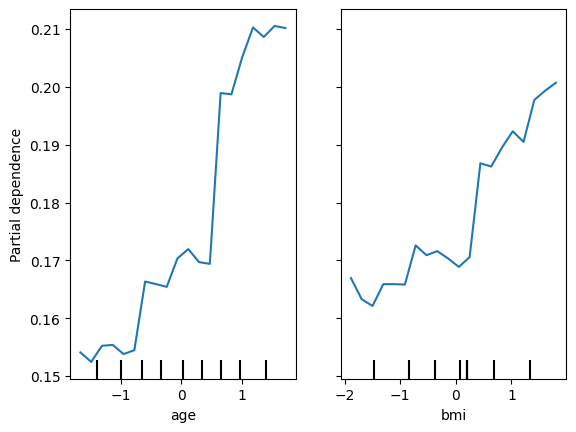

In [20]:
#Partial Dependence for two features
PartialDependenceDisplay.from_estimator(
    voting, X_test, ['age', 'bmi'],
    feature_names=X.columns, grid_resolution=20
)
plt.show()

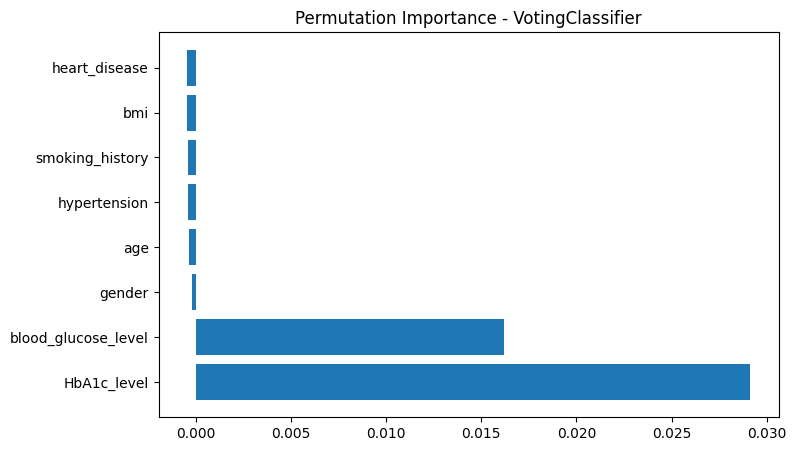

In [23]:
#  Permutation Importance
perm = permutation_importance(voting, X_test, y_test, n_repeats=10, random_state=42)
df_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean
}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8,5))
plt.barh(df_imp['Feature'], df_imp['Importance'])
plt.title("Permutation Importance - VotingClassifier")
plt.show()


In [28]:
import lime
import lime.lime_tabular

# LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    discretize_continuous=True
)

i = 0
exp = explainer.explain_instance(
    X_test[i], voting.predict_proba, num_features=len(X.columns)
)

exp.show_in_notebook(show_table=True, show_all=False)

In [40]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

z_scores = np.abs((X_test_scaled - np.mean(X_test_scaled, axis=0)) / np.std(X_test_scaled, axis=0))

z_scores_df = pd.DataFrame(z_scores, columns=X.columns)

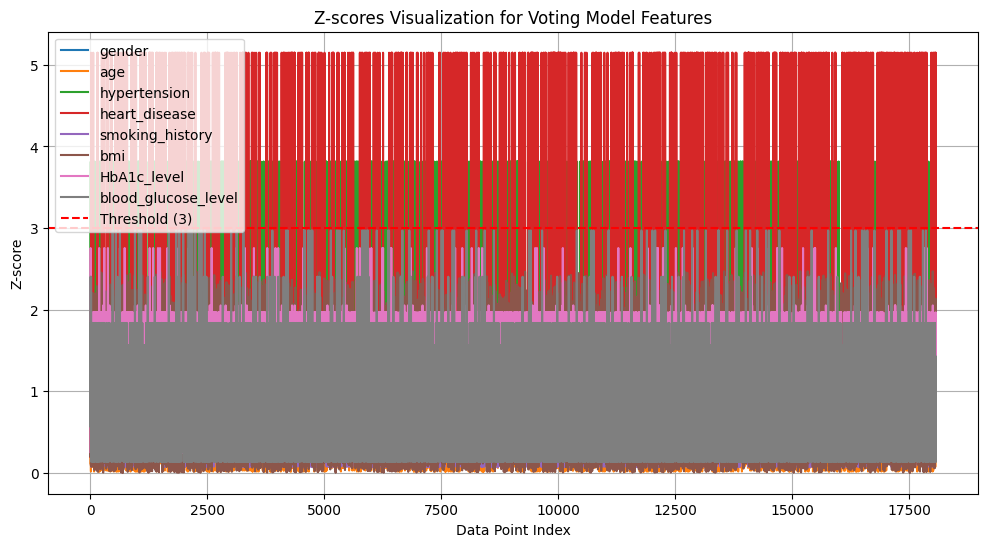

In [39]:
# Visualize the Z-scores
plt.figure(figsize=(12, 6))
for col in z_scores_df.columns:
    plt.plot(z_scores_df[col], label=col)
plt.axhline(y=3, color='r', linestyle='--', label='Threshold (3)')
plt.xlabel("Data Point Index")
plt.ylabel("Z-score")
plt.title("Z-scores Visualization for Voting Model Features")
plt.legend()
plt.grid(True)
plt.show()